In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets

from matplotlib import pyplot as plt
from os import listdir, path, curdir
from os.path import isfile, join
from pathlib import Path
from tqdm import tqdm
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_general_statistics(state, data, statistics):
    statistics['state'].append(state)
    statistics['electorate'].append(data['QT_APTOS'].sum())
    statistics['turnout'].append(data['QT_COMPARECIMENTO'].sum())
    statistics['polling_places'].append(len(data.groupby('id')))
    return statistics

def generate_statistics(election_data, data_filter='all'):
    statistics = {
        'state': [],
        'electorate': [],
        'turnout':[],
        'polling_places': [],
        '
    }

    for state, data in election_data:
        #filtering data if needed
        if data_filter == 'Capital':
            data = data[data['capital'] == True]
        elif data_filter == 'Rural':
            data = data[data['rural'] == True]

        #General statistics
        statistics = generate_general_statistics(state, data, statistics)
        #Precision statistics
        #statistics = generate_precision_statistics(data, statistics)

    return pd.DataFrame(statistics)

In [3]:
def generate_electorate_size_plot(election_statistics, field):

    election_statistics['%'+field] = 100* election_statistics[
        field] / election_statistics[field].sum()
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout()
    
    plot_electorate = sns.barplot(ax=ax[0],
                                  x='state',
                                  y= field,
                                  data=election_statistics,
                                  color='#59a2cb'
                                  )
    if field == 'electorate': 
        title = "Electorate Size"
    elif field == 'turnout':
        title = "Turnout"
    ax[0].title.set_text(title)
    ax[0].set(xlabel="", ylabel = "Number of voters (1e7)")
    ax[0].set_xticks([])
    
    plot_electorate = sns.barplot(ax=ax[1],
                                  x='state',
                                  y='%'+field,
                                  data=election_statistics,
                                  color='#f85050'
                                 )
    ax[1].set(xlabel="States", ylabel = "Percentual of voters (%)")
    
    
    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    return(fig)

def stacked_data(election_statistics, capital_election_statistics, rural_election_statistics, field='electorate'):
    #Set general plot properties
    #sns.set_style("white")
    sns.set_context({"figure.figsize": (30, 17)})

    #Plot 1 - background - "total" (top) series
    sns.barplot(x=election_statistics.state,
                y=election_statistics[field],
                color="#f85050")

    #Plot 2 - overlay - "bottom" series
    series_to_plot = capital_election_statistics[field] + rural_election_statistics[field]
    middle_plot = sns.barplot(x=rural_election_statistics.state,
                              y=series_to_plot,
                              color="#2b7c56")

    #Plot 3 - overlay - "bottom" series
    bottom_plot = sns.barplot(x=capital_election_statistics.state,
                              y=capital_election_statistics[field],
                              color="#59a2cb")

    topbar = plt.Rectangle((0, 0), 1, 1, fc="#f85050", edgecolor='none')
    bottombar = plt.Rectangle((0, 0), 1, 1, fc='#59a2cb', edgecolor='none')
    middlebar = plt.Rectangle((0, 0), 1, 1, fc='#2b7c56', edgecolor='none')

    l = plt.legend([bottombar, middlebar, topbar],
                   ['Capital', 'Rural', 'Interior'],
                   loc=1,
                   ncol=3,
                   prop={'size': 25})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    #sns.despine(left=True)
    bottom_plot.set_ylabel("Number of voters (1e7)")
    bottom_plot.set_xlabel("States")

    #Set fonts to consistent 16pt size
    for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
                 bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
        item.set_fontsize(25)

# Step 1 - Load the data

<b>Select the folder where all electoral data are:</b>

In [4]:
# Create and display a FileChooser widget
ROOT_DIR = path.abspath(curdir)
fc = FileChooser(ROOT_DIR)
fc.use_dir_icons = True
#fc.title = '<b>Choose a folder</b>'

election_data = []
def load_data(chooser):
    global election_data
    
    selected_path = chooser.selected_path
    try:
        filenames = [
            filename for filename in listdir(selected_path)
            if isfile(join(selected_path, filename))
        ]

        for file in tqdm(filenames):
            data = pd.read_csv(selected_path + '\\' + file)
            state = file.split('.')[0]
            election_data = election_data + [(state, data)]
    except:
        print("An erro occur, please check the folder selected.")


# Register callback function
fc.register_callback(load_data)
display(fc)

FileChooser(path='C:\Users\Tiago\Documents\GitHub\Election_Forensics\notebooks\report', filename='', show_hidd…

100%|██████████████████████████████████████████| 27/27 [00:04<00:00,  6.24it/s]


# Step 2 - Filter the data

<b>Select the type of area to filter the data:</b>

In [5]:
dropdown_area = widgets.Dropdown(options=['All', 'Capital', 'Rural'])
output_table = widgets.Output()
output_electorate_plot = widgets.Output()
output_turnout_plot = widgets.Output()


def dropdown_area_eventhandler(change):
    output_table.clear_output()
    output_electorate_plot.clear_output()
    output_turnout_plot.clear_output() 

    election_statistics = generate_statistics(election_data,
                                              data_filter=change.new)
    with output_table:
        display(election_statistics)
    with output_electorate_plot:
        plot = generate_electorate_size_plot(election_statistics,
                                             field='electorate')
        plt.show()
    with output_turnout_plot:
        plot = generate_electorate_size_plot(election_statistics,
                                             field='turnout')
        plt.show()


dropdown_area.observe(dropdown_area_eventhandler, names='value')

display(dropdown_area)
#display(output_table)

Dropdown(options=('All', 'Capital', 'Rural'), value='All')

# <center> Data Visualization </center> 

## Electorate size plot
This plot represents the size of the electorate per state. It is possible to change the plot by selecting specific areas. The percentages presented in this plot are calculated considering the sum of all states number of voters for the type of area selected (All, Capital, or Rural). 

In [6]:
display(output_electorate_plot)

Output()

## Electorate size stacked plot
This plot shows the composition of the electorate by areas (Capital, Rural, Interior)
PS: Run this cell after loading the data.

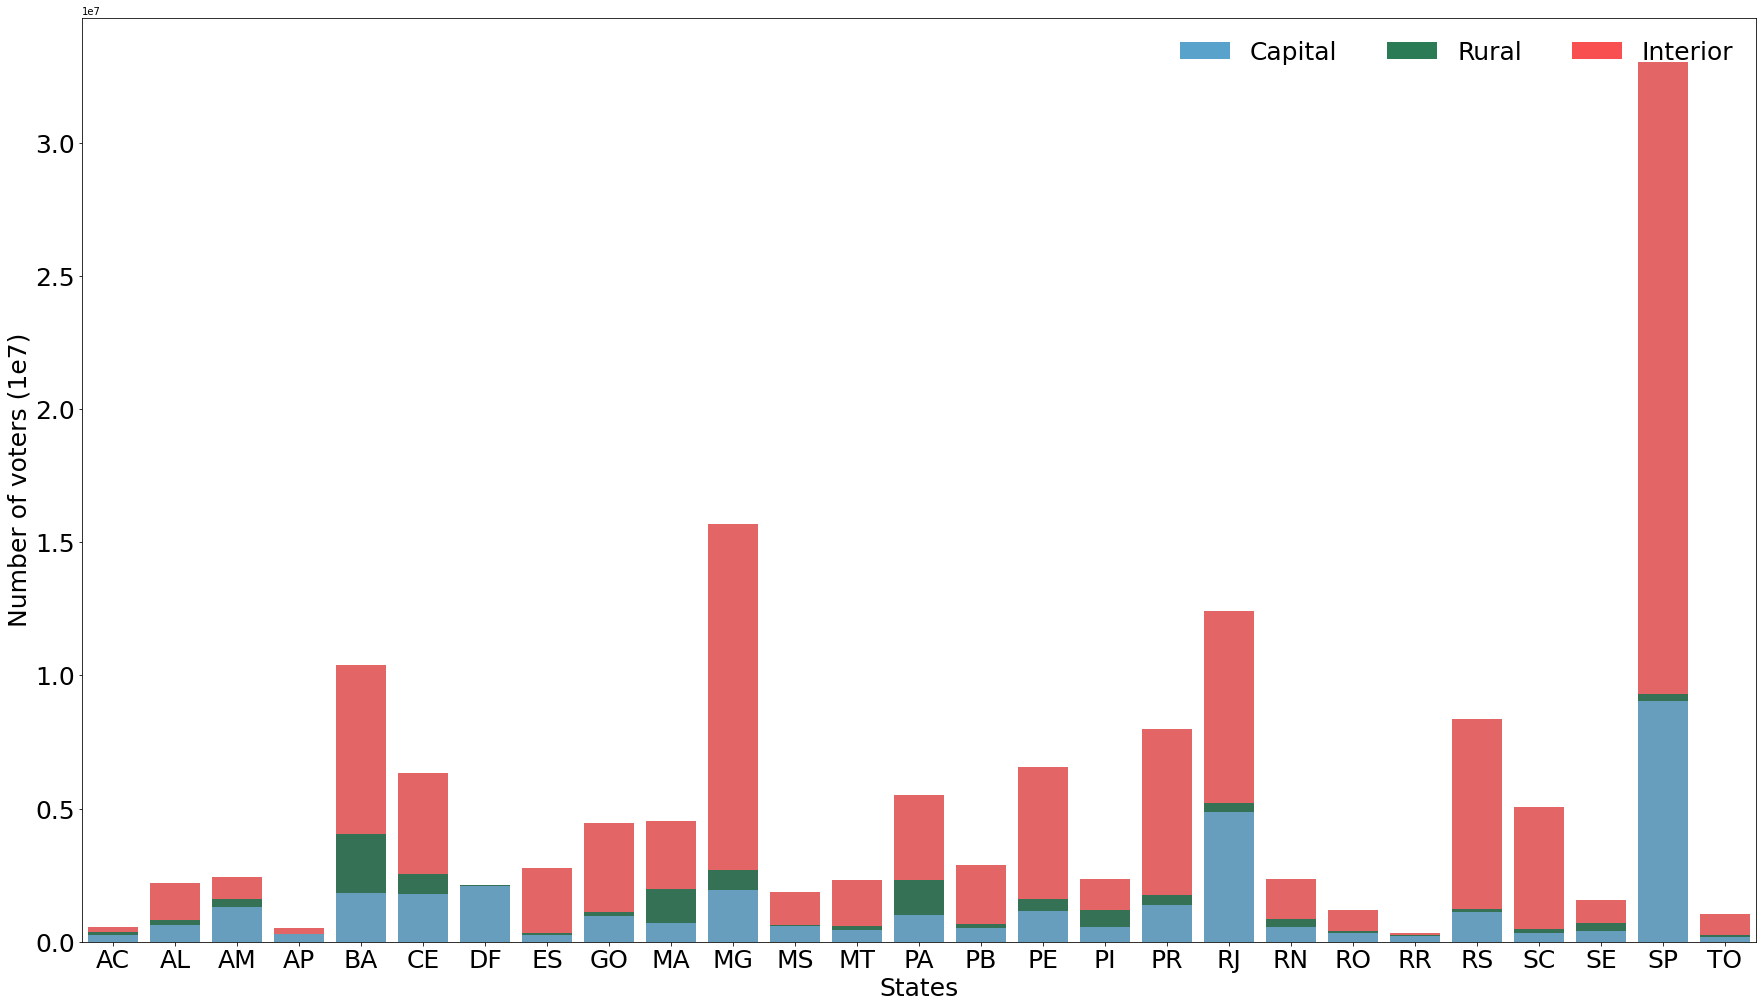

In [14]:
try:
    interior_statistics = generate_statistics(election_data, data_filter= 'All')
    capital_statistics = generate_statistics(election_data, data_filter= 'Capital')
    rural_statistics = generate_statistics(election_data, data_filter= 'Rural')

    stacked_data(interior_statistics, capital_statistics, rural_statistics)
except:
    print("An error occur, please check the selected folder.")

## Turnout plot
This plot represents the turnout of the electorate per state. It is possible to change the plot by selecting specific areas in the Step 2. The percentages presented in this plot are calculated considering the sum of all states number of voters for the type of area selected (All, Capital, or Rural). 

In [8]:
display(output_turnout_plot)

Output()

## Turnout stacked plot
This plot shows the composition of the turnout electorate by areas (Capital, Rural, Interior)
PS: Run this cell after loading the data.

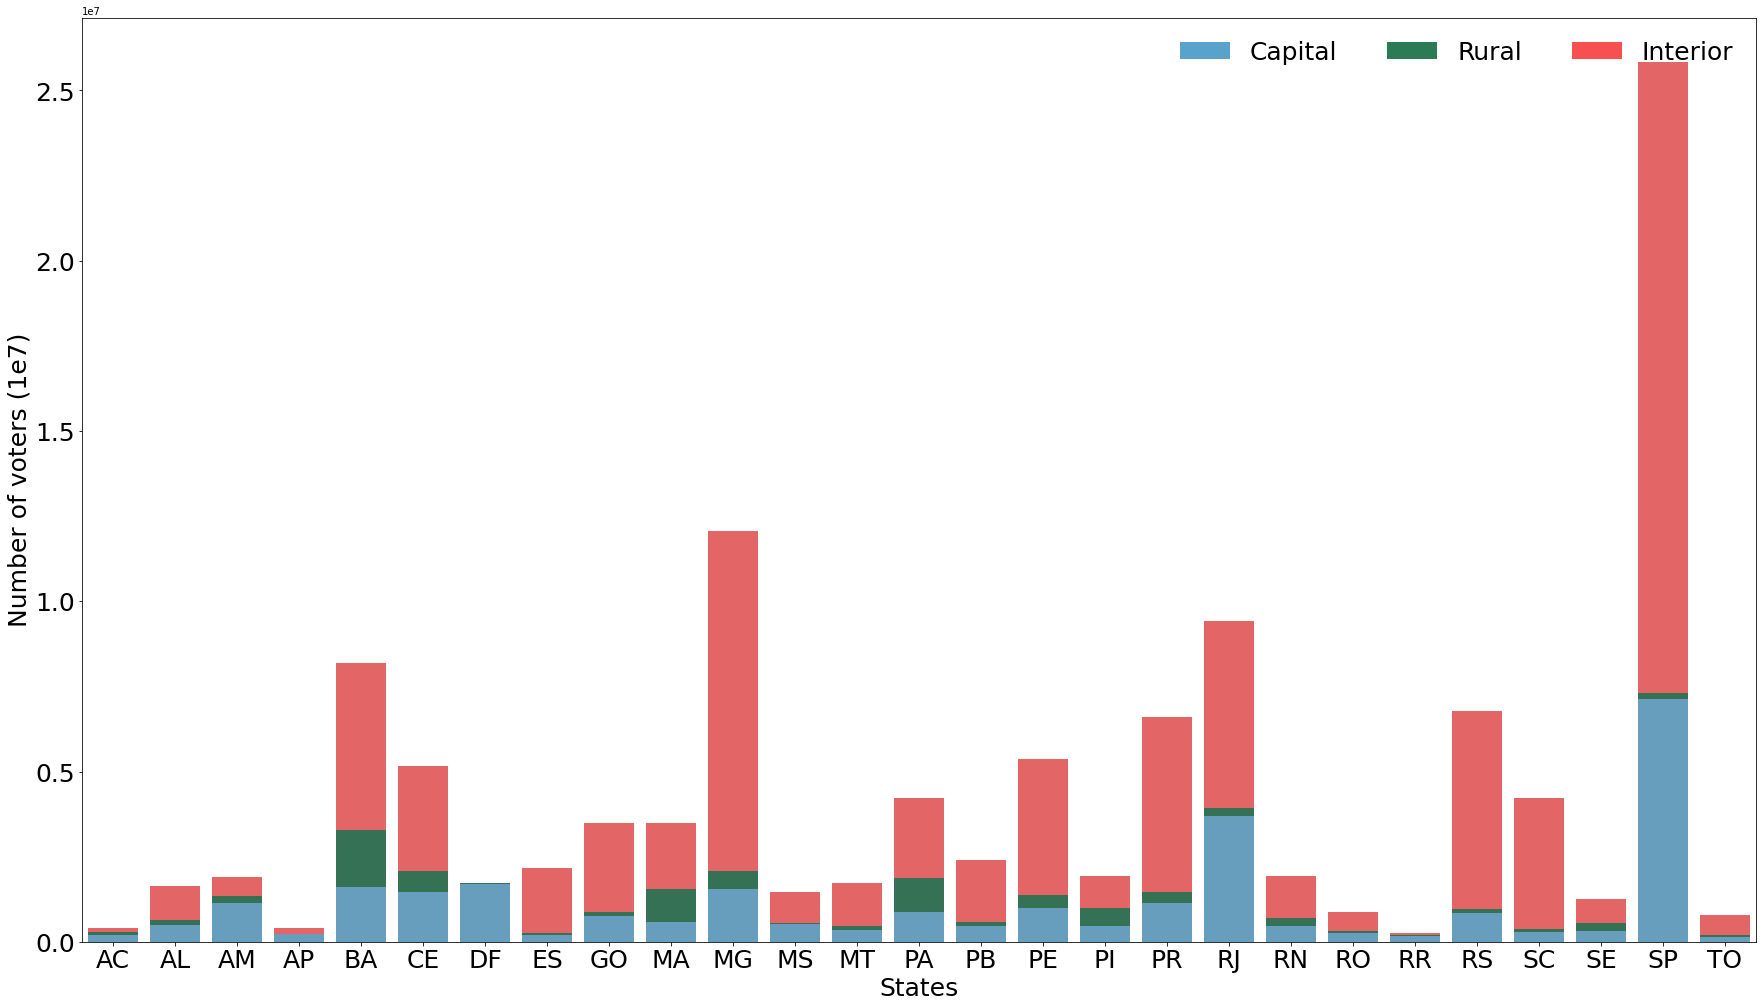

In [15]:
try:
    stacked_data(interior_statistics, capital_statistics, rural_statistics, field='turnout')
except:
    print("An error occur, please check the selected folder.")

# <center> Analysis </center>


Although the capitals present a huge percentage of the electorate, most of the electorate seems to be in the interior cities, specially in the state of São Paulo that presents around 20% of the total electorate size. Moreover, the rural areas seems to have a small percentage regarding the total, and are more present in the northeastern and northern regions. Finally, the proportion of electorate size and turnout does not changed for this data.

In [16]:
total_size = interior_statistics.electorate.sum()
capital_size = capital_statistics.electorate.sum()
rural_size = rural_statistics.electorate.sum()
interior_size = total_size - capital_size - rural_size
print("Electorate size - Total:{}, Interior:{}, Capitals:{}, Rural:{}".format(
    total_size, interior_size, capital_size, rural_size))

Electorate size - Total:146830967, Interior:101407045, Capitals:34794638, Rural:10629284


In [17]:
interior_perc = 100*interior_size/total_size
capital_perc = 100*capital_size/total_size
rural_perc = 100*rural_size/total_size
print("Electorate size (%) - Interior:{}, Capitals:{}, Rural:{}".format(interior_perc, capital_perc, rural_perc))

Electorate size (%) - Interior:69.0637997364684, Capitals:23.697070659488336, Rural:7.239129604043267


In [18]:
total_size = interior_statistics.turnout.sum()
capital_size = capital_statistics.turnout.sum()
rural_size = rural_statistics.turnout.sum()
interior_size = total_size - capital_size - rural_size
print("Turnout - Total:{}, Interior:{}, Capitals:{}, Rural:{}".format(
    total_size, interior_size, capital_size, rural_size))

Turnout - Total:115754230, Interior:79534871, Capitals:28064268, Rural:8155091


In [19]:
interior_perc = 100*interior_size/total_size
capital_perc = 100*capital_size/total_size
rural_perc = 100*rural_size/total_size
print("Turnout (%) - Interior:{}, Capitals:{}, Rural:{}".format(interior_perc, capital_perc, rural_perc))

Turnout (%) - Interior:68.71012057183569, Capitals:24.244701899878734, Rural:7.045177528285575
